In [1]:
import selfies as sf
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import torch
import torch.nn as nn
import random, glob, os
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rdkit import Chem
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
df = pd.read_csv('../smiles_selfies_full.csv')

### Tokenization

In [3]:
df['tokens'] = df['selfies'].apply(lambda x: list(sf.split_selfies(x)))

all_tokens =  [tok for seq in df['tokens'] for tok in seq]
vocab = sorted(set(all_tokens))
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
vocab = [PAD, SOS, EOS] + vocab

tok2id = {tok: idx for idx, tok in enumerate(vocab)}
id2tok = {idx: tok for tok, idx in tok2id.items()}

def tokens_to_ids(tokens, tok2id):
    return np.array([tok2id[t] for t in tokens])

df['token_ids'] = df['tokens'].apply(lambda toks: tokens_to_ids(toks, tok2id))
df['lenghts'] = df['token_ids'].apply(len)

### Data prep

In [4]:
sequences = df['token_ids'].tolist()
max_len = max(len(seq) for seq in sequences)
padded_data = np.zeros((len(sequences), max_len), dtype=sequences[0].dtype)

for i, seq in enumerate(sequences):
    padded_data[i, :len(seq)] = seq

data = padded_data
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
val_data, test_data = train_test_split(data, test_size=0.5, random_state=42, shuffle=True)
print(max_len)

75


### Model

In [6]:
class BaselineVAE(nn.Module):
    def __init__(self, vocab_size, max_len, embed_size=64, hidden_size=128, latent_size=64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.start_T = 5
        self.max_len = max_len

        self.encoder = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=5, padding=2, dilation=1),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=4, dilation=2),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=8, dilation=4),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=16, dilation=8),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=32, dilation=8),
            nn.ReLU(),
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

        self.fc_z = nn.Linear(latent_size, hidden_size * self.start_T)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, kernel_size=7, stride=1, padding=3)
        )        
        self.output_fc = nn.Linear(hidden_size, vocab_size)

    def encode(self, x):
        h = self.embed(x).transpose(1,2)
        h = self.encoder(h)
        h = self.pool(h).squeeze(-1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def decode(self, z):
        B = z.size(0)
        h = self.fc_z(z)
        h = h.view(B, self.hidden_size, self.start_T)
        h = self.decoder(h)            # [B, H, T]
        h = h[:, :, :self.max_len]
        logits = self.output_fc(h.transpose(1, 2))  # [B, T, vocab]
        return logits
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        logits = self.decode(z)
        return logits, mu, logvar
    
    def encode_sequence(self, x, batch_size=256):
        self.eval()
        device = next(self.parameters()).device
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.long)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        loader = DataLoader(TensorDataset(x), batch_size=batch_size)
        logits_list, mu_list, logvar_list = [], [], []
        with torch.no_grad():
            for (bx,) in loader:
                bx = bx.to(device)
                logits, mu, logvar = self(bx)
                mu_list.append(mu.cpu())
                logvar_list.append(logvar.cpu())
        mu = torch.cat(mu_list, dim=0)
        logvar = torch.cat(logvar_list, dim=0)
        return logits, mu, logvar
    
def vae_loss(logits, x, mu, logvar, beta=0.1, pad_id=0):
    B, T, V = logits.shape
    logits_flat = logits.reshape((B*T, V))
    targets_flat = x[:, :T].reshape(B*T)

    mask = (targets_flat != pad_id)
    valid_logits = logits_flat[mask]
    valid_targets = targets_flat[mask]
    
    rec_loss = F.cross_entropy(valid_logits, valid_targets)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    loss = rec_loss + beta * kl_loss
    return loss, rec_loss, kl_loss

### Training

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

embed_size = 128
hidden_size = 256
latent_size = 128

model = BaselineVAE(vocab_size=len(vocab), max_len=train_data.shape[-1], embed_size=embed_size, hidden_size=hidden_size, latent_size=latent_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, )

epochs = 50
beta = 0.01
batch_size = 1024

train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=True)
history = []

ckpt = torch.load("trained_models/tcn_vae_baseline_128.pt", map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])
history = ckpt["history"]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=4, factor=0.5, min_lr=1e-5, verbose=True)

for epoch in range(1, epochs + 1):
    model.train()
    total_recon = 0
    total_kl = 0
    val_recon = 0
    val_kl = 0

    for x in tqdm(train_loader):
        x = x.to(device)

        logits, mu, logvar = model(x)        
        loss, rec, kl = vae_loss(logits, x, mu, logvar, beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_recon += rec.item()
        total_kl += kl.item()
    
    with torch.no_grad():
        for x in val_loader:
            x = x.to(device)
            logits, mu, logvar = model(x)
            loss, rec, kl = vae_loss(logits, x, mu, logvar, beta)
            val_recon += rec.item()
            val_kl += kl.item()

    val_loss = (val_recon + val_kl) / len(val_loader)
    history.append(((total_recon+total_kl)/len(train_loader), total_recon / len(train_loader), total_kl / len(train_loader), val_loss, optimizer.param_groups[0]["lr"]))
    print(f"Epoch {epoch:03d} | total={(total_recon+total_kl)/len(train_loader):.4f} | recon={total_recon/len(train_loader):.4f} | KL={total_kl/len(train_loader):.4f} | val={val_loss:.4f}")
    scheduler.step(val_loss)


/home/pedro/ml_praca/miniforge3/envs/mlenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 001 | total=1.3684 | recon=0.0218 | KL=1.3466 | val=1.3797


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 002 | total=1.5060 | recon=0.0673 | KL=1.4387 | val=1.3930


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 003 | total=1.3661 | recon=0.0210 | KL=1.3451 | val=1.3622


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 004 | total=1.4421 | recon=0.0512 | KL=1.3910 | val=1.3337


100%|██████████| 621/621 [01:31<00:00,  6.80it/s]


Epoch 005 | total=1.3541 | recon=0.0211 | KL=1.3330 | val=1.3367


100%|██████████| 621/621 [01:31<00:00,  6.80it/s]


Epoch 006 | total=1.3549 | recon=0.0230 | KL=1.3319 | val=1.3502


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 007 | total=1.3527 | recon=0.0251 | KL=1.3275 | val=1.3004


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 008 | total=1.3258 | recon=0.0222 | KL=1.3036 | val=1.3211


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 009 | total=1.4570 | recon=0.0681 | KL=1.3889 | val=1.3279


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 010 | total=1.3086 | recon=0.0186 | KL=1.2900 | val=1.3217


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 011 | total=1.3056 | recon=0.0202 | KL=1.2854 | val=1.3178


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 012 | total=1.4775 | recon=0.0787 | KL=1.3988 | val=1.3391


100%|██████████| 621/621 [01:31<00:00,  6.79it/s]


Epoch 013 | total=1.2295 | recon=0.0106 | KL=1.2189 | val=1.2095


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 014 | total=1.2216 | recon=0.0098 | KL=1.2119 | val=1.2042


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 015 | total=1.2274 | recon=0.0106 | KL=1.2168 | val=1.2028


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 016 | total=1.2247 | recon=0.0111 | KL=1.2136 | val=1.2193


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 017 | total=1.2186 | recon=0.0112 | KL=1.2074 | val=1.1841


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 018 | total=1.2142 | recon=0.0113 | KL=1.2029 | val=1.2074


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 019 | total=1.2044 | recon=0.0111 | KL=1.1933 | val=1.2151


100%|██████████| 621/621 [01:31<00:00,  6.80it/s]


Epoch 020 | total=1.1935 | recon=0.0131 | KL=1.1804 | val=1.1338


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 021 | total=1.1631 | recon=0.0087 | KL=1.1544 | val=1.1553


100%|██████████| 621/621 [01:32<00:00,  6.74it/s]


Epoch 022 | total=1.2002 | recon=0.0153 | KL=1.1849 | val=1.1588


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 023 | total=1.1322 | recon=0.0075 | KL=1.1247 | val=1.1537


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 024 | total=1.1494 | recon=0.0086 | KL=1.1408 | val=1.1040


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 025 | total=1.1687 | recon=0.0179 | KL=1.1508 | val=1.1033


100%|██████████| 621/621 [01:31<00:00,  6.80it/s]


Epoch 026 | total=1.1156 | recon=0.0068 | KL=1.1087 | val=1.1447


100%|██████████| 621/621 [01:32<00:00,  6.75it/s]


Epoch 027 | total=1.1349 | recon=0.0081 | KL=1.1268 | val=1.1551


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 028 | total=1.1436 | recon=0.0089 | KL=1.1347 | val=1.1206


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 029 | total=1.1356 | recon=0.0098 | KL=1.1258 | val=1.1618


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 030 | total=1.1258 | recon=0.0082 | KL=1.1176 | val=1.1302


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 031 | total=1.0485 | recon=0.0043 | KL=1.0442 | val=1.0609


100%|██████████| 621/621 [01:32<00:00,  6.74it/s]


Epoch 032 | total=1.0454 | recon=0.0040 | KL=1.0414 | val=1.0669


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 033 | total=1.0574 | recon=0.0044 | KL=1.0531 | val=1.0473


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 034 | total=1.0621 | recon=0.0045 | KL=1.0577 | val=1.0565


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 035 | total=1.0609 | recon=0.0045 | KL=1.0565 | val=1.0811


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 036 | total=1.0582 | recon=0.0044 | KL=1.0538 | val=1.0549


100%|██████████| 621/621 [01:32<00:00,  6.75it/s]


Epoch 037 | total=1.0517 | recon=0.0043 | KL=1.0474 | val=1.0536


100%|██████████| 621/621 [01:30<00:00,  6.82it/s]


Epoch 038 | total=1.0514 | recon=0.0043 | KL=1.0471 | val=1.0485


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 039 | total=0.9927 | recon=0.0024 | KL=0.9902 | val=0.9751


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 040 | total=0.9884 | recon=0.0023 | KL=0.9861 | val=0.9832


100%|██████████| 621/621 [01:31<00:00,  6.81it/s]


Epoch 041 | total=0.9886 | recon=0.0022 | KL=0.9864 | val=0.9967


100%|██████████| 621/621 [01:32<00:00,  6.75it/s]


Epoch 042 | total=0.9909 | recon=0.0023 | KL=0.9886 | val=0.9965


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 043 | total=0.9897 | recon=0.0022 | KL=0.9875 | val=0.9888


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 044 | total=0.9883 | recon=0.0022 | KL=0.9861 | val=0.9860


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 045 | total=0.9563 | recon=0.0016 | KL=0.9547 | val=0.9582


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 046 | total=0.9510 | recon=0.0015 | KL=0.9495 | val=0.9618


100%|██████████| 621/621 [01:31<00:00,  6.76it/s]


Epoch 047 | total=0.9486 | recon=0.0015 | KL=0.9471 | val=0.9442


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 048 | total=0.9484 | recon=0.0015 | KL=0.9470 | val=0.9540


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 049 | total=0.9464 | recon=0.0015 | KL=0.9449 | val=0.9501


100%|██████████| 621/621 [01:31<00:00,  6.82it/s]


Epoch 050 | total=0.9449 | recon=0.0014 | KL=0.9435 | val=0.9641


In [15]:
new_history = []
for i, h in enumerate(history):
    if len(h) == 4:
        new_history.append((*h, 1e-3))
    else:
        new_history.append(h)
history = new_history

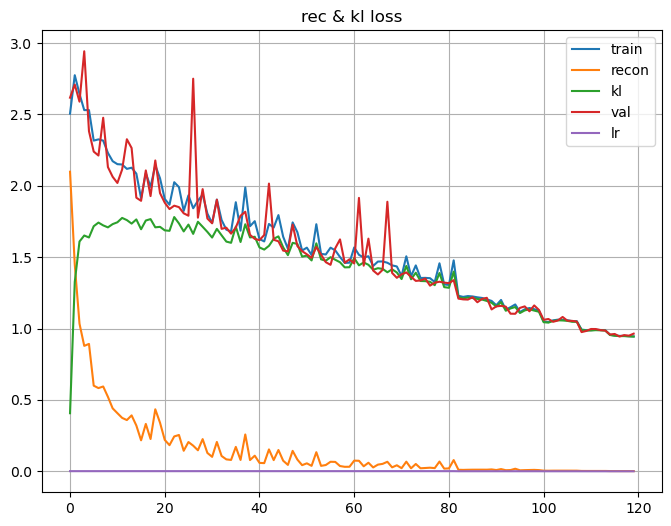

In [17]:
plt.figure(figsize=(8,6))
plt.plot(np.array(history)[:, 0], label='train')
plt.plot(np.array(history)[:, 1], label='recon')
plt.plot(np.array(history)[:, 2], label='kl')
plt.plot(np.array(history)[:, 3], label='val')
plt.plot(np.array(history)[:, 4], label='lr')
plt.title('rec & kl loss')
plt.legend()
plt.grid()
plt.show()

In [66]:
ckpt = {"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "history": history,"vocab_size": len(vocab)}
torch.save(ckpt, "trained_models/tcn_vae_baseline_128.pt")

In [18]:
logits, mu, logvar = model.encode_sequence(val_data)
z = mu
z = z.cpu().numpy()

### latent PCA

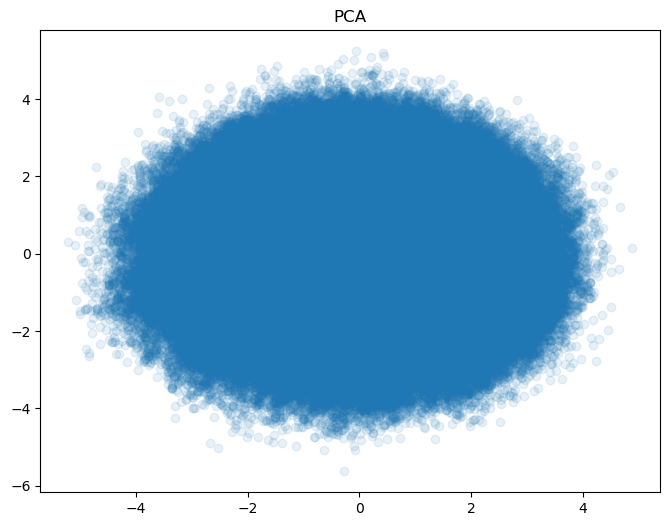

In [19]:
pca_z = PCA(n_components=2).fit_transform(z)
plt.figure(figsize=(8,6))
plt.scatter(pca_z[:, 0], pca_z[:, 1], alpha=0.1)
plt.title('PCA')
plt.show()

### Testing latent

In [20]:
def tokens_to_selfie(tokens):
    selfie_tokens = [id2tok[int(id)] for id in tokens]
    return str(selfie_tokens)

In [21]:
x = val_data[0:1]
print(x.shape)
logits, mu, logvar = model.encode_sequence(x)
print(logits.shape)
tokens = torch.argmax(logits, dim=-1)
print(tokens_to_selfie(x[0]))
print(tokens_to_selfie(tokens[0]))

(1, 75)
torch.Size([1, 75, 110])
['[C]', '[C]', '[=C]', '[Branch1]', '[C]', '[F]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[#Branch1]', '[C@@]', '[C]', '[C]', '[C@@H1]', '[Branch1]', '[Ring2]', '[C]', '[Ring1]', '[Branch1]', '[O]', '[C]', '[Ring1]', '[#Branch1]', '[=O]', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['[C]', '[C]', '[=C]', '[Branch1]', '[C]', '[F]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[#Branch1]', '[C@@]', '[C]', '[C]', '[C@@H1]', '[Branch1]', '[Ring2]', '[C]', '[Ring1]', '[Branch1]', '[O]', '[C]', '[Ring1]', '[#Branch1]', '[=O]', '[=O]', '[=O]', '[=O]', '[=O]', '[Ring2]', '

In [22]:
def get_accuracy_samples(model, data, pad_id=0, num_samples=5):
    model.eval()    
    for _ in range(num_samples):
        i = np.random.randint(0, len(data))
        x = data[i]
        x = x[np.newaxis, :]
        logits, mu, logvar = model.encode_sequence(x)
        x_rec = torch.argmax(logits, dim=-1)
        acc, pad = 0, 0
        j = 0
        x = x.squeeze(0)
        x_rec = x_rec.squeeze(0)
        while x[j] != pad_id:
            pad += 1
            if x[j] == x_rec[j]:
                acc += 1
            j+=1
        acc = acc / pad
        print(f"real: {tokens_to_selfie(x)}")
        print(f"rec: {tokens_to_selfie(x_rec)}")
        print(f"accuracy: {acc}")
        print('------------------------------')

In [23]:
get_accuracy_samples(model, test_data, pad_id=0, num_samples=5)

real: ['[N]', '[C]', '[=N]', '[C]', '[Branch2]', '[Ring1]', '[C]', '[C]', '[=C]', '[C]', '[Branch1]', '[C]', '[F]', '[=C]', '[Branch1]', '[C]', '[F]', '[C]', '[Branch1]', '[C]', '[F]', '[=C]', '[Ring1]', '[=Branch2]', '[=N]', '[C]', '[=C]', '[Ring1]', '[#C]', '[N]', '[=C]', '[N]', '[Ring1]', '[Branch1]', '[C@@H1]', '[O]', '[C@H1]', '[Branch1]', '[Ring1]', '[C]', '[O]', '[C@@H1]', '[Branch1]', '[C]', '[O]', '[C@H1]', '[Ring1]', '[Branch2]', '[O]', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
rec: ['[N]', '[C]', '[=N]', '[C]', '[Branch2]', '[Ring1]', '[C]', '[C]', '[=C]', '[C]', '[Branch1]', '[C]', '[F]', '[=C]', '[Branch1]', '[C]', '[F]', '[C]', '[Branch1]', '[C]', '[F]', '[=C]', '[Ring1]', '[=Branch2]', '[=N]', '[C]', '[=C]', '[Ring1]', '[#C]', '[N]', '[=C]', '[N]', '[Ring1]', '[Branch1]', '[C@@H1]',

In [24]:
def get_accuracy(model, data, pad_id=0, batch_size=64):
    model.eval()
    all_accs = []
    perfect = 0
    with torch.no_grad():
        for b in range(0, len(data), batch_size):
            batch = data[b : b + batch_size]              
            batch = torch.tensor(batch, device='cuda')  
            logits, mu, logvar = model.encode_sequence(batch)   
            preds = torch.argmax(logits, dim=-1)                
            mask = (batch != pad_id)                            
            correct = (batch == preds) & mask                   
            acc = correct.sum(dim=1).float() / mask.sum(dim=1)
            all_accs.extend(acc.cpu().tolist())
            perfect += (acc == 1).sum().item()
    print(f"reconstructed correctly {perfect} out of {len(data)} molecules")
    print(f"correct rec %: {perfect*100 / len(data):.2f}%")
    print(f"mean accuracy: {np.mean(all_accs)*100:.2f}%")

In [25]:
get_accuracy(model, test_data)

reconstructed correctly 376721 out of 397202 molecules
correct rec %: 94.84%
mean accuracy: 99.80%


### Visualisations

In [26]:
logits, mu, logvar = model.encode_sequence(data)
z = mu
z.cpu().numpy()

array([[ 0.01086425,  0.33993417,  0.13259652, ...,  0.7759409 ,
        -0.51857126,  1.0534161 ],
       [-0.384529  , -0.12863374, -0.01616895, ..., -0.9367501 ,
        -0.307315  ,  0.44096747],
       [ 0.5911153 ,  1.6893637 ,  0.8745643 , ...,  0.74775004,
         0.48807853,  1.0234601 ],
       ...,
       [-0.04809219,  0.49451292, -0.5972132 , ..., -0.27096784,
        -0.385216  , -0.4378569 ],
       [-0.20063365,  0.95589405, -0.05017961, ...,  0.6091388 ,
         0.47286826, -0.15422487],
       [ 0.34252423, -0.7759765 ,  0.08289154, ..., -0.72022426,
         0.22489342,  0.01323408]], dtype=float32)

In [27]:
n_samples = 5000
idxs = np.random.choice(z.shape[0], size=n_samples, replace=False)
z_sample = z[idxs]
len_labels = len_labels = np.array(df['lenghts'])[idxs]
z_sample.shape

torch.Size([5000, 128])

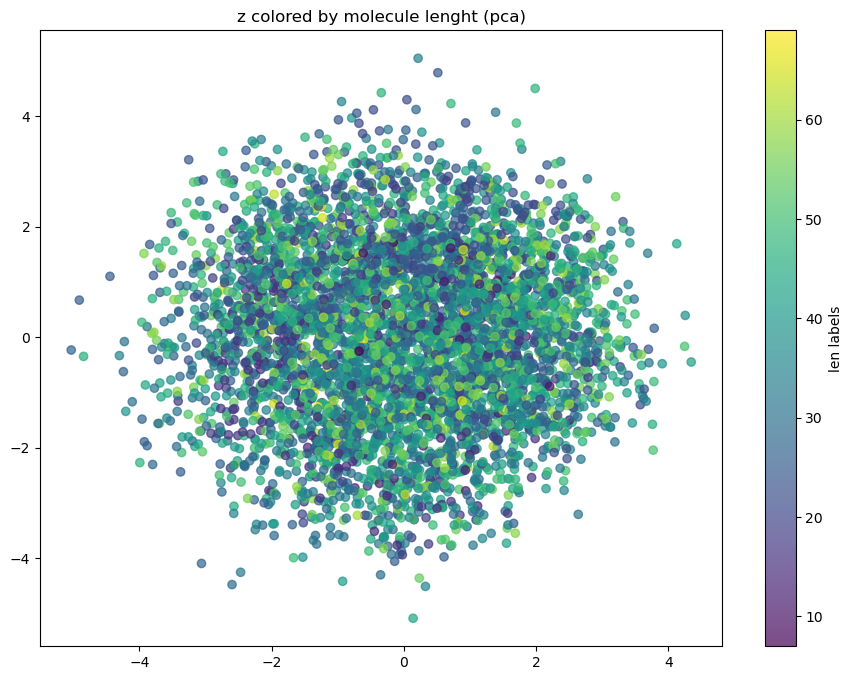

In [28]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (pca)')
plt.colorbar(label='len labels')
plt.show()

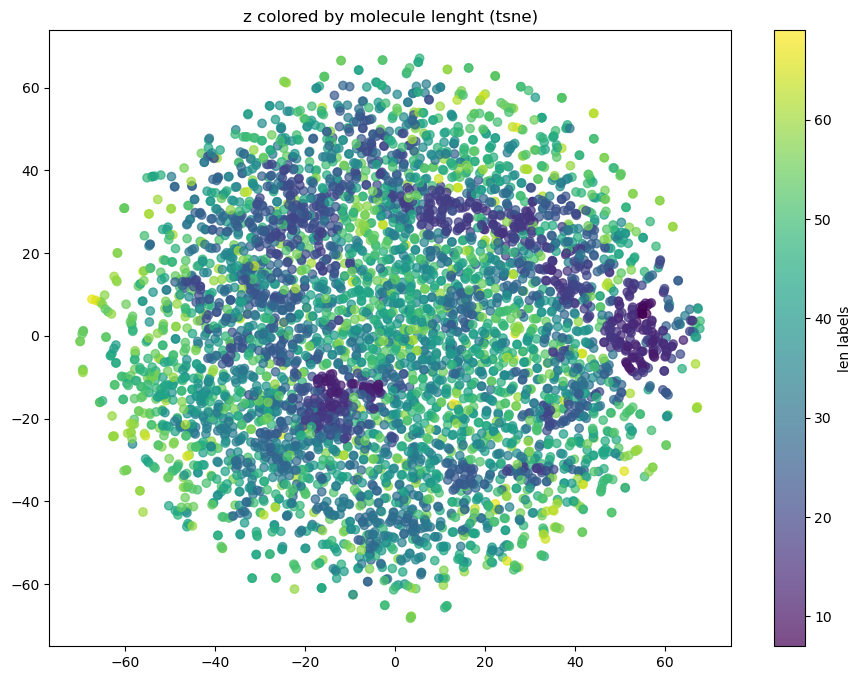

In [29]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (tsne)')
plt.colorbar(label='len labels')
plt.show()

In [30]:
oxygen_labels = df['selfies'].apply(lambda x: 1 if 'O' in x else 0)[idxs]

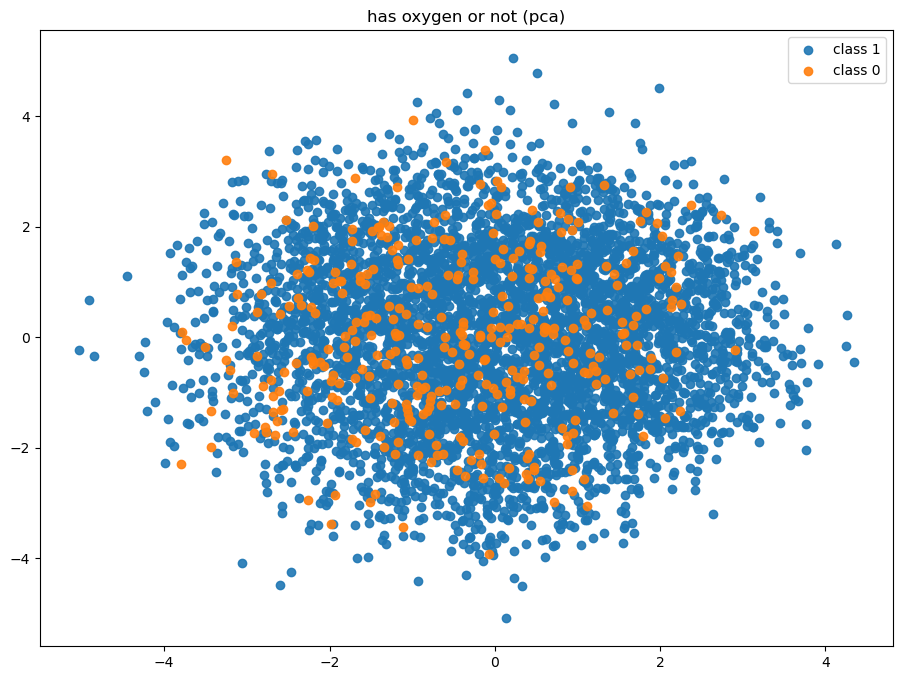

In [31]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (pca)')
plt.legend()
plt.show()

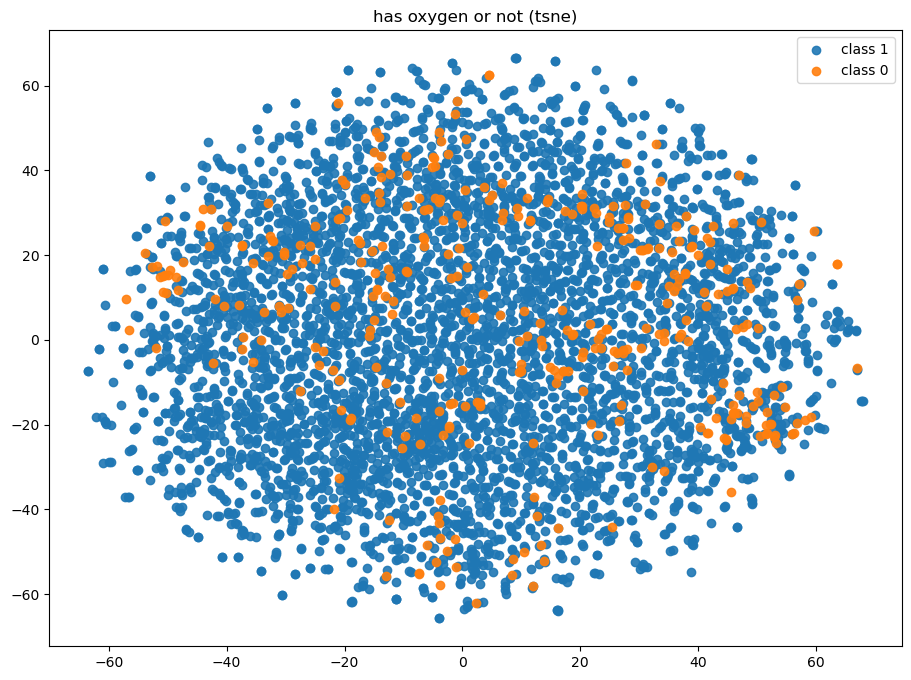

In [32]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (tsne)')
plt.legend()
plt.show()

In [33]:
carbon_label =  df['selfies'].apply(lambda x: x.count('C'))[idxs]

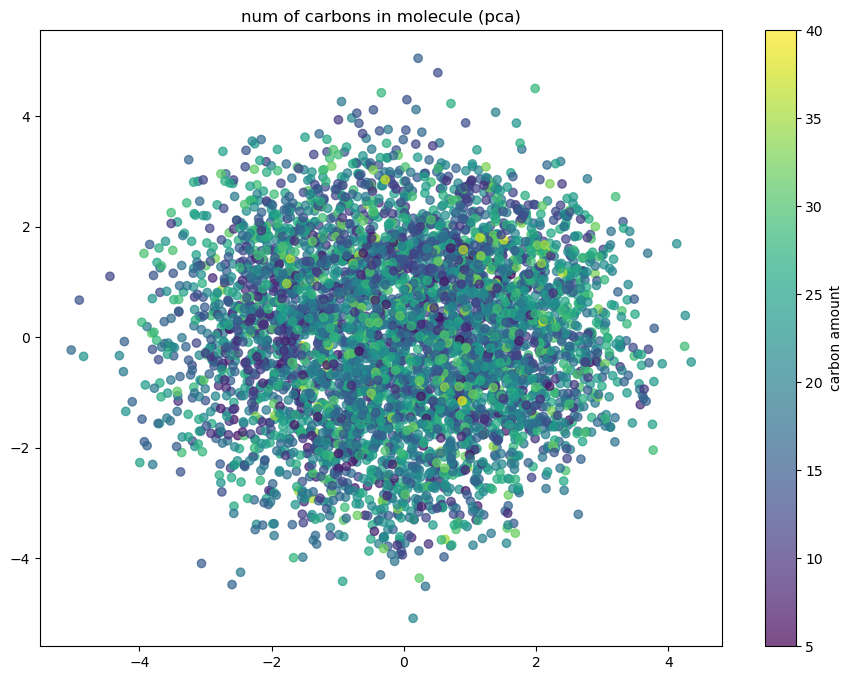

In [34]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=carbon_label, cmap="viridis", alpha=0.7)
plt.title(label='num of carbons in molecule (pca)')
plt.colorbar(label='carbon amount')
plt.show()

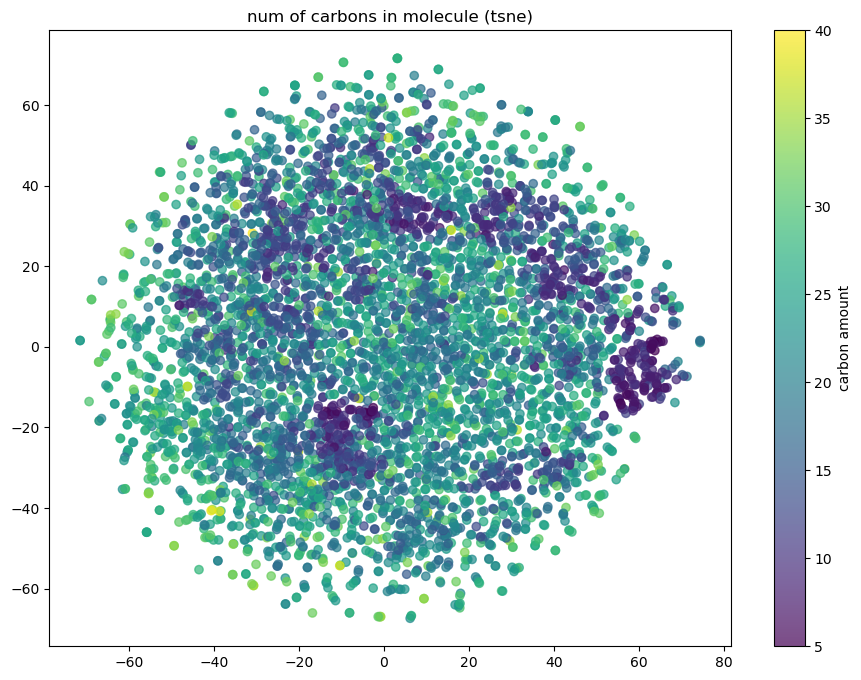

In [35]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=carbon_label, cmap="viridis", alpha=0.7)
plt.title(label='num of carbons in molecule (tsne)')
plt.colorbar(label='carbon amount')
plt.show()